# Unsupervised Learning

In unsupervised learning, labels are either not available or are not used for learning. Clustering is a form of unsupervised learning whereby, without labels, the data is characterized by constraints alone.
LTN can formulate such constraints, such as for example: 
- clusters should be disjoint,
- every example should be assigned to a cluster,
- a cluster should not be empty,
- if the points are near, they should belong to the same cluster,
- if the points are far, they should belong to different clusters.

In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ltn

Init Plugin
Init Graph Optimizer
Init Kernel


## Data

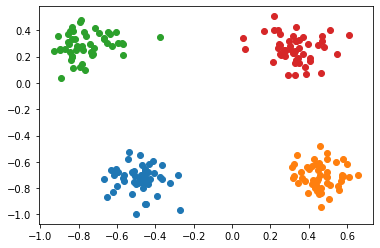

In [2]:
# loading data

nr_of_clusters = 4
nr_of_points_x_cluster = 50
clst_ids = range(nr_of_clusters)

close_threshold = 0.2
distant_threshold = 1.0

margin = .2
mean = [np.random.uniform([-1+margin,-1+margin],[0-margin,0-margin],2),
       np.random.uniform([0+margin,-1+margin],[1-margin,0-margin],2),
       np.random.uniform([-1+margin,0+margin],[0-margin,1-margin],2),
       np.random.uniform([0+margin,0+margin],[1-margin,1-margin],2)]

cov = np.array([[[.01,0],[0,.01]]]*nr_of_clusters)

cluster_data = {}
for i in clst_ids:
    cluster_data[i] = np.random.multivariate_normal(mean=mean[i],cov=cov[i],size=nr_of_points_x_cluster)

data  = np.concatenate([cluster_data[i] for i in clst_ids])

for i in clst_ids:
    plt.scatter(cluster_data[i][:, 0], cluster_data[i][:, 1])

## Language

In [3]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Equiv = ltn.Wrapper_Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.And_Prod(),ltn.fuzzy_ops.Implies_Reichenbach()))
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=4),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=6),semantics="exists")

In [4]:
from tensorflow.keras import layers

class MLP_classifier(tf.keras.Model):
    """ Model to call as P(x,class) """
    def __init__(self, n_classes, single_label, hidden_layer_sizes=(16,16,16)):
        super(MLP_classifier, self).__init__()
        self.denses = [layers.Dense(s, activation="elu") for s in hidden_layer_sizes]
        self.dense_class = layers.Dense(n_classes)
        self.to_probs = tf.nn.softmax if single_label else tf.math.sigmoid
        
    def call(self, inputs):
        x, c = inputs[0], inputs[1]
        for dense in self.denses:
            x = dense(x)
        logits = self.dense_class(x)
        probs = self.to_probs(logits)
        indices = tf.cast(c, tf.int32)
        return tf.gather(probs, indices, batch_dims=1) 

C = ltn.Predicate(MLP_classifier(nr_of_clusters, single_label=True))
cluster = ltn.Variable("cluster",clst_ids)

x = ltn.Variable("x",data)
y = ltn.Variable("y",data)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-10-15 18:53:14.098343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-15 18:53:14.098434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Notice that we use a clustering predicate that ends in a `softmax` layer (`single_label=True`), which returns mutually-exclusive probabilities for each cluster.
Therefore, there is no explicit constraint in the knowledgebase about clusters being disjoint. 

Notice also the use of guarded quantifiers in the two last axioms: all the pairs of points with Euclidean distance lower (resp. higher) than some threshold should belong in the same cluster (resp.should not). The thresholds (`0.2` and `1.0` in this case) do not have to explicitly define all existing pairs of points as "close" or "distant"; they only define *some of* the closest and most distant pairs of points.

In [5]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

eucl_dist = ltn.Function.Lambda(lambda inputs: tf.expand_dims(tf.norm(inputs[0]-inputs[1],axis=1),axis=1))
is_greater_than = ltn.Predicate.Lambda(lambda inputs: inputs[0] > inputs[1])

close_thr = ltn.Constant(close_threshold, trainable=False)
distant_thr = ltn.Constant(distant_threshold, trainable=False)

# defining the theory
#@tf.function
def axioms(p_exists):
    axioms = [
        Forall(x, Exists(cluster, C([x,cluster]),p=p_exists)),
        Forall(cluster, Exists(x, C([x,cluster]),p=p_exists)),
        Forall([cluster,x,y], Equiv(C([x,cluster]),C([y,cluster])),
            mask = is_greater_than([close_thr,eucl_dist([x,y])])),
        Forall([cluster,x,y], Not(And(C([x,cluster]),C([y,cluster]))),
            mask = is_greater_than([eucl_dist([x,y]),distant_thr]))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level


In [6]:
# first call to build the graph
axioms(p_exists=6)

<tf.Tensor: shape=(), dtype=float32, numpy=0.46333975>

## Training

In [7]:
trainable_variables = C.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(1000):
    if epoch <= 100:
        p_exists = 1
    else:
        p_exists = 6
    with tf.GradientTape() as tape:
        loss_value = 1. - axioms(p_exists=p_exists)
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%100 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms(p_exists=p_exists)))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms(p_exists=p_exists)))

Epoch 0: Sat Level 0.441
Epoch 100: Sat Level 0.442
Epoch 200: Sat Level 0.641
Epoch 300: Sat Level 0.849
Epoch 400: Sat Level 0.852
Epoch 500: Sat Level 0.853
Epoch 600: Sat Level 0.853
Epoch 700: Sat Level 0.853
Epoch 800: Sat Level 0.854
Epoch 900: Sat Level 0.854
Training finished at Epoch 999 with Sat Level 0.854


## Print result

In [8]:
plt.rcParams['font.size'] = 12

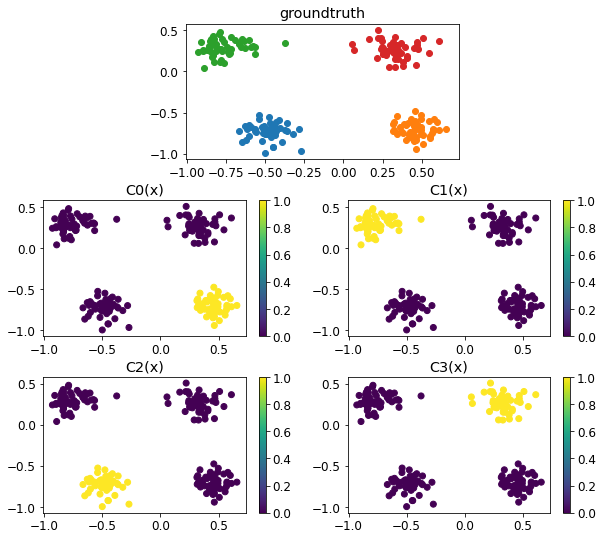

In [9]:
x0 = data[:, 0]
x1 = data[:, 1]

prC = [C.model([data, tf.constant([[i]]*len(data))]) for i in clst_ids]
n = 2
m = (nr_of_clusters + 1) // n + 1

fig = plt.figure(figsize=(10, m * 3))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
ax = plt.subplot2grid((m,8),(0,2),colspan=4)
ax.set_title("groundtruth")
for i in clst_ids:
    ax.scatter(cluster_data[i][:, 0], cluster_data[i][:, 1])
for i in clst_ids:
    fig.add_subplot(m, n, i + 3)
    plt.title("C" + str(i) + "(x)")
    plt.scatter(x0, x1, c=prC[i],vmin=0,vmax=1)
    plt.colorbar()
# plt.savefig("ex_clustering_test.pdf")
plt.show()